In [62]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True
import pandas as pd
import datetime as dt

In [63]:
def replace_timestamps_with_step_times(df):
    step_names = ["prefetch", "fasterq_dump", "salmon", "deseq2_salmon", "star", "deseq2_star"]
    for step_name in step_names:
        if step_name+"_start_time" in df.columns:
            start_times = (pd.to_datetime(df[f"{step_name}_start_time"]) - dt.datetime(1970,1,1)).dt.total_seconds()
            end_times = (pd.to_datetime(df[f"{step_name}_end_time"]) - dt.datetime(1970,1,1)).dt.total_seconds()
            df[f"{step_name} [s]"] = end_times - start_times

    return df

In [64]:
df_108 = pd.read_csv("data/release_108_results.csv", index_col=0)
df_111 = pd.read_csv("data/release_111_results.csv", index_col=0)
df_108 = replace_timestamps_with_step_times(df_108)
df_111 = replace_timestamps_with_step_times(df_111)

In [66]:
df_108 = df_108[["SRR_id", "index_release", "fasterq_dump [s]", "star [s]", "STAR_mapping_rate [%]"]]

df_111["fastq_filesize_[GiB]"] = df_111["fastq_filesize_bytes"] / 1024**3
df_111 = df_111[["SRR_id", "index_release", "fasterq_dump [s]", "star [s]", "fastq_filesize_[GiB]", "n_spots", "STAR_mapping_rate [%]"]]

df_merged = df_111.merge(df_108, on="SRR_id", how="inner", suffixes=("_111", "_108"))

In [73]:
df_merged["STAR_speedup"] = df_merged["star [s]_108"] / df_merged["star [s]_111"]
df_merged[sorted(df_merged.columns)][:2]

,SRR_id,STAR_mapping_rate [%]_108,STAR_mapping_rate [%]_111,STAR_speedup,fasterq_dump [s]_108,fasterq_dump [s]_111,fastq_filesize_[GiB],index_release_108,index_release_111,n_spots,star [s]_108,star [s]_111
0,SRR24501796,91.61,90.97,7.524306,35.0,20.0,15.903350,108,111,22234431,2167.0,288.0
1,SRR13933701,91.21,90.51,32.573770,11.0,11.0,6.811693,108,111,21145340,1987.0,61.0


In [68]:
print(f"Average .fastq filesize: {df_111['fastq_filesize_[GiB]'].mean().round(2)}")

weighted_mean = ((df_merged['STAR_speedup'] * df_merged['fastq_filesize_[GiB]']).sum() / df_merged['fastq_filesize_[GiB]'].sum()).round(2)
print(f"Weighted mean for speedup : {weighted_mean}")

mapping_rate_diff = (df_merged["STAR_mapping_rate [%]_108"] - df_merged["STAR_mapping_rate [%]_111"]).mean().round(2)
print(f"Mean mapping rate difference: {mapping_rate_diff}")

Average .fastq filesize: 15.87
Weighted mean for speedup : 12.15
Mean mapping rate difference: 0.63


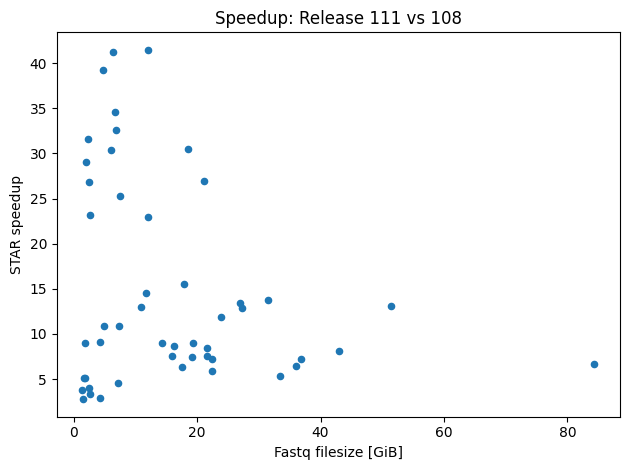

In [69]:
df_merged.sort_values(by='fastq_filesize_[GiB]').plot.scatter(x="fastq_filesize_[GiB]", y="STAR_speedup", title="Speedup: Release 111 vs 108", xlabel="Fastq filesize [GiB]", ylabel="STAR speedup");
# plt.savefig("release_111_speedup.pdf")

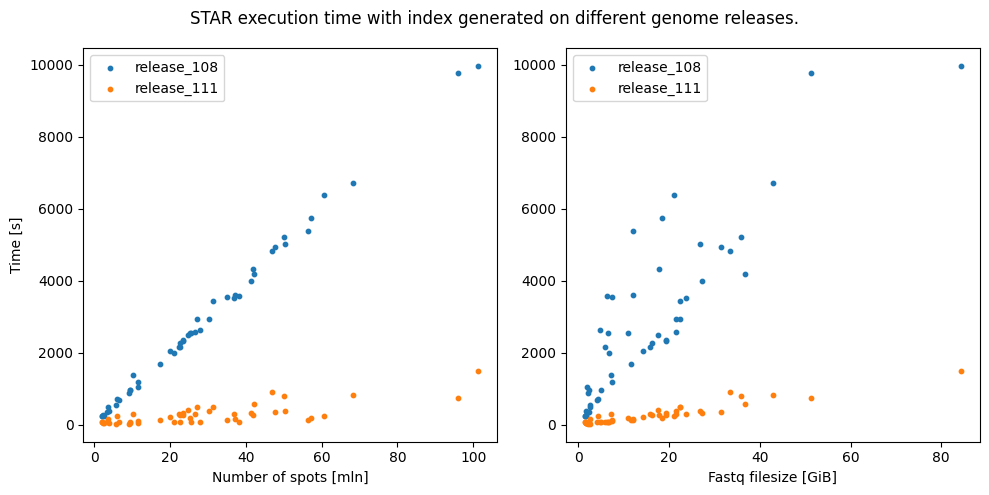

In [72]:
# df_111.plot.scatter(x="n_spots", y="star [s]");

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].scatter(df_merged['n_spots'] / 1000**2, df_merged['star [s]_108'], label='release_108', s=10)
ax[0].scatter(df_merged['n_spots'] / 1000**2, df_merged['star [s]_111'], label='release_111', s=10)

ax[1].scatter(df_merged['fastq_filesize_[GiB]'], df_merged['star [s]_108'], label='release_108', s=10)
ax[1].scatter(df_merged['fastq_filesize_[GiB]'], df_merged['star [s]_111'], label='release_111', s=10)

ax[0].set_xlabel('Number of spots [mln]')
ax[1].set_xlabel('Fastq filesize [GiB]')
ax[0].set_ylabel('Time [s]')
fig.suptitle('STAR execution time with index generated on different genome releases.')

ax[0].legend()
ax[1].legend()
plt.tight_layout()
# plt.savefig('.pdf')
plt.show()